In [ ]:
import kagglehub
robikscube_hourly_energy_consumption_path = kagglehub.dataset_download('robikscube/hourly-energy-consumption')

print('Data source import complete.')

Data source import complete.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [ ]:
import os

# List the contents of the dataset folder to check the files
print(os.listdir(robikscube_hourly_energy_consumption_path))


['est_hourly.paruqet', 'DOM_hourly.csv', 'EKPC_hourly.csv', 'DUQ_hourly.csv', 'DAYTON_hourly.csv', 'PJME_hourly.csv', 'PJM_Load_hourly.csv', 'NI_hourly.csv', 'FE_hourly.csv', 'COMED_hourly.csv', 'AEP_hourly.csv', 'pjm_hourly_est.csv', 'DEOK_hourly.csv', 'PJMW_hourly.csv']


In [ ]:
# Define the path to the PJME_hourly.csv file
csv_file_path = os.path.join(robikscube_hourly_energy_consumption_path, 'PJME_hourly.csv')

# Load the CSV file into a DataFrame
df = pd.read_csv(csv_file_path)

# Show the first few rows to verify the data
print(df.head())

              Datetime  PJME_MW
0  2002-12-31 01:00:00  26498.0
1  2002-12-31 02:00:00  25147.0
2  2002-12-31 03:00:00  24574.0
3  2002-12-31 04:00:00  24393.0
4  2002-12-31 05:00:00  24860.0


In [ ]:
# Convert 'Datetime' column to pandas datetime
df['Datetime'] = pd.to_datetime(df['Datetime'])

# Set 'Datetime' as the index of the DataFrame
df = df.set_index('Datetime')

# Check the first few rows after modification
print(df.head())


                     PJME_MW
Datetime                    
2002-12-31 01:00:00  26498.0
2002-12-31 02:00:00  25147.0
2002-12-31 03:00:00  24574.0
2002-12-31 04:00:00  24393.0
2002-12-31 05:00:00  24860.0


#**1.Plotting**

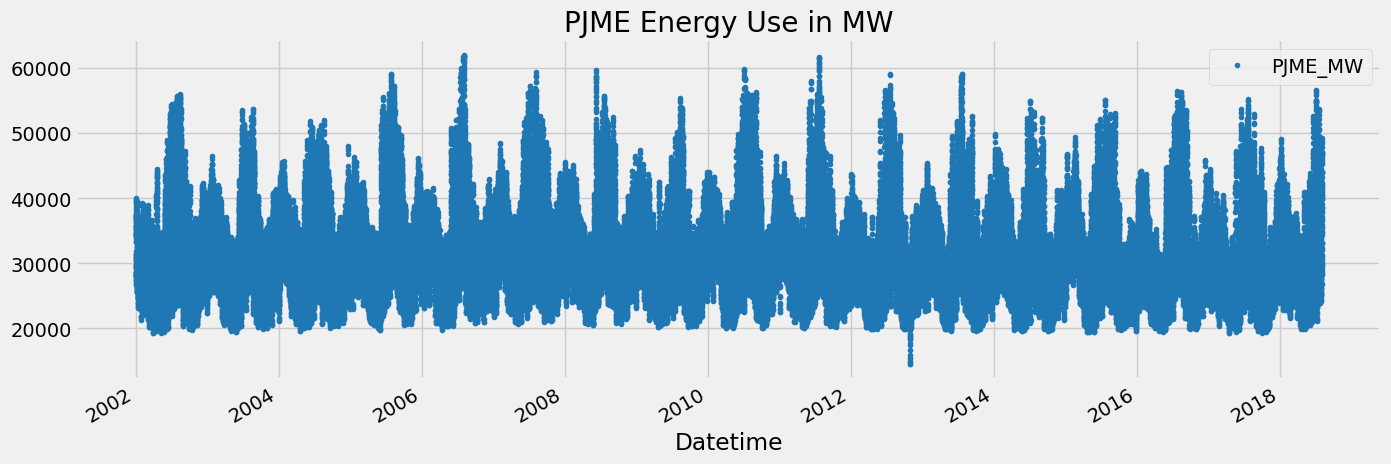

In [ ]:
df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='PJME Energy Use in MW')
plt.show()

#**2.Train/Test Split**

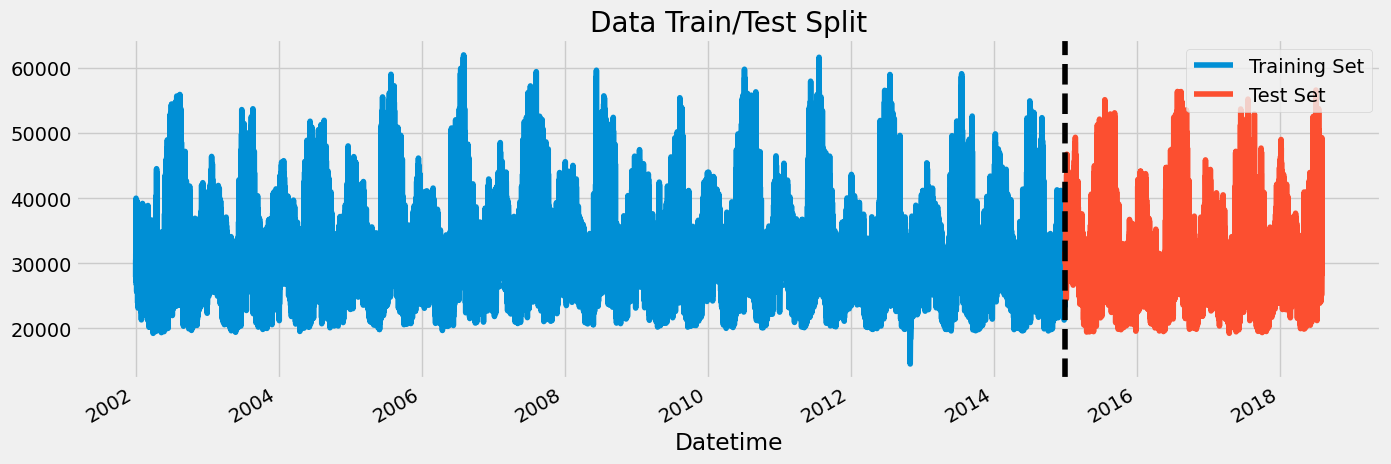

In [ ]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

<ipython-input-13-b92e09a746a4>:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.resample('H').mean()


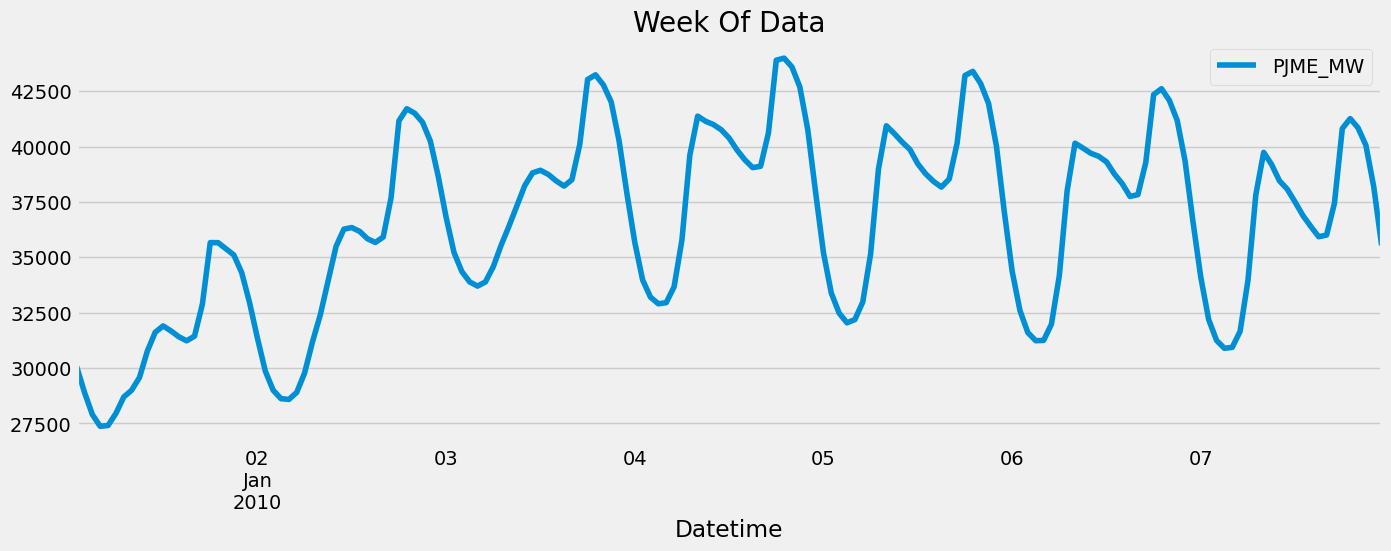

In [ ]:
df = df.resample('H').mean()

df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')] \
    .plot(figsize=(15, 5), title='Week Of Data')
plt.show()

#**4.Feature Creation**

In [ ]:
def create_features(df):

    #Create time series features based on time series index.

    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

#**5.Visualize our Feature / Target Relationship**

##**Monthly**

<ipython-input-9-7e1b289e90be>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='month', y='PJME_MW', palette='Spectral', ax=ax)


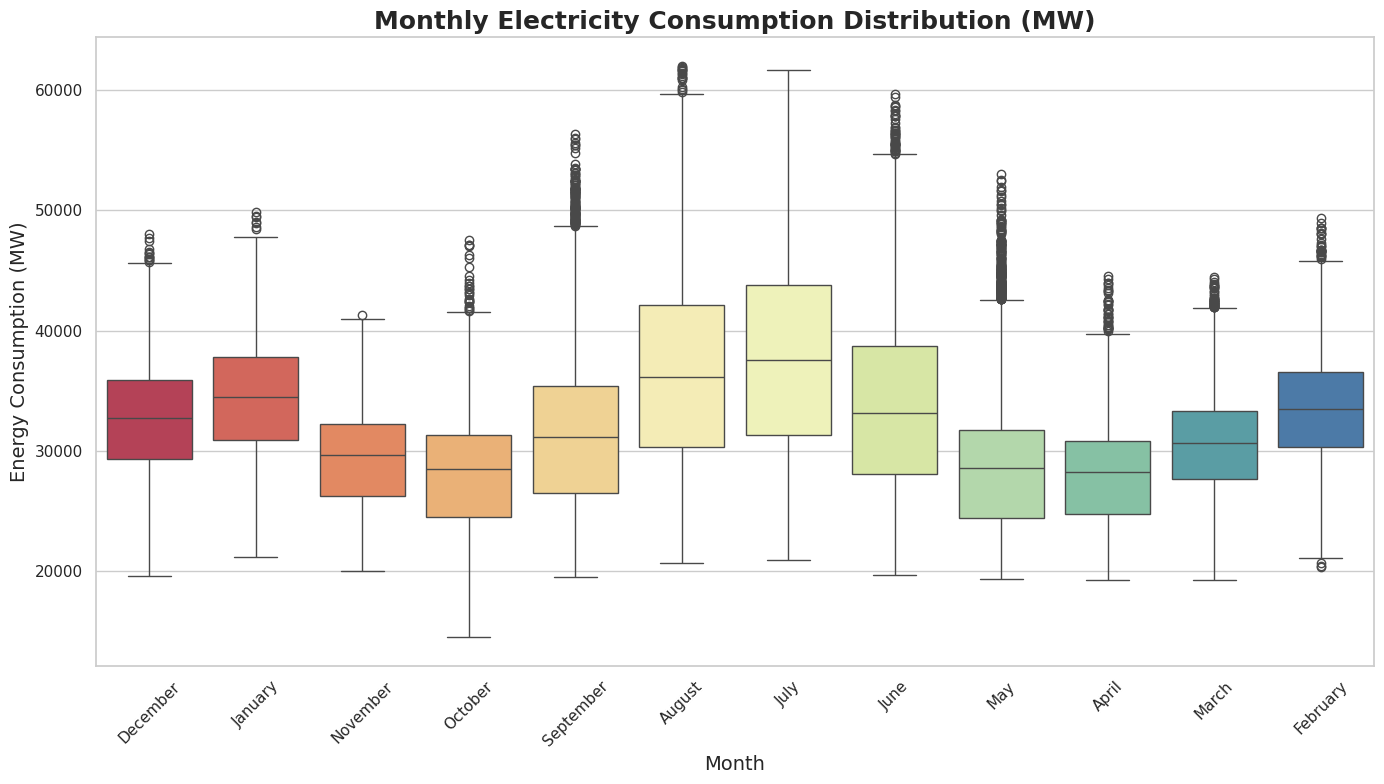

In [ ]:
# Firstly:
df.index = pd.to_datetime(df.index)

# Add a month column (you can use month names or numbers)
df['month'] = df.index.month_name()   # Use df.index.month for numbers (1-12)

import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid")

# Create the plot
fig, ax = plt.subplots(figsize=(14, 8))

# Plot with a beautiful color palette
sns.boxplot(data=df, x='month', y='PJME_MW', palette='Spectral', ax=ax)

# Labels and title
ax.set_title('Monthly Electricity Consumption Distribution (MW)', fontsize=18, fontweight='bold')
ax.set_xlabel('Month', fontsize=14)
ax.set_ylabel('Energy Consumption (MW)', fontsize=14)

# Rotate x-axis labels if needed
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()



##**Hourly**

<ipython-input-10-833207c72534>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='hour', y='PJME_MW', palette=palette, ax=ax)


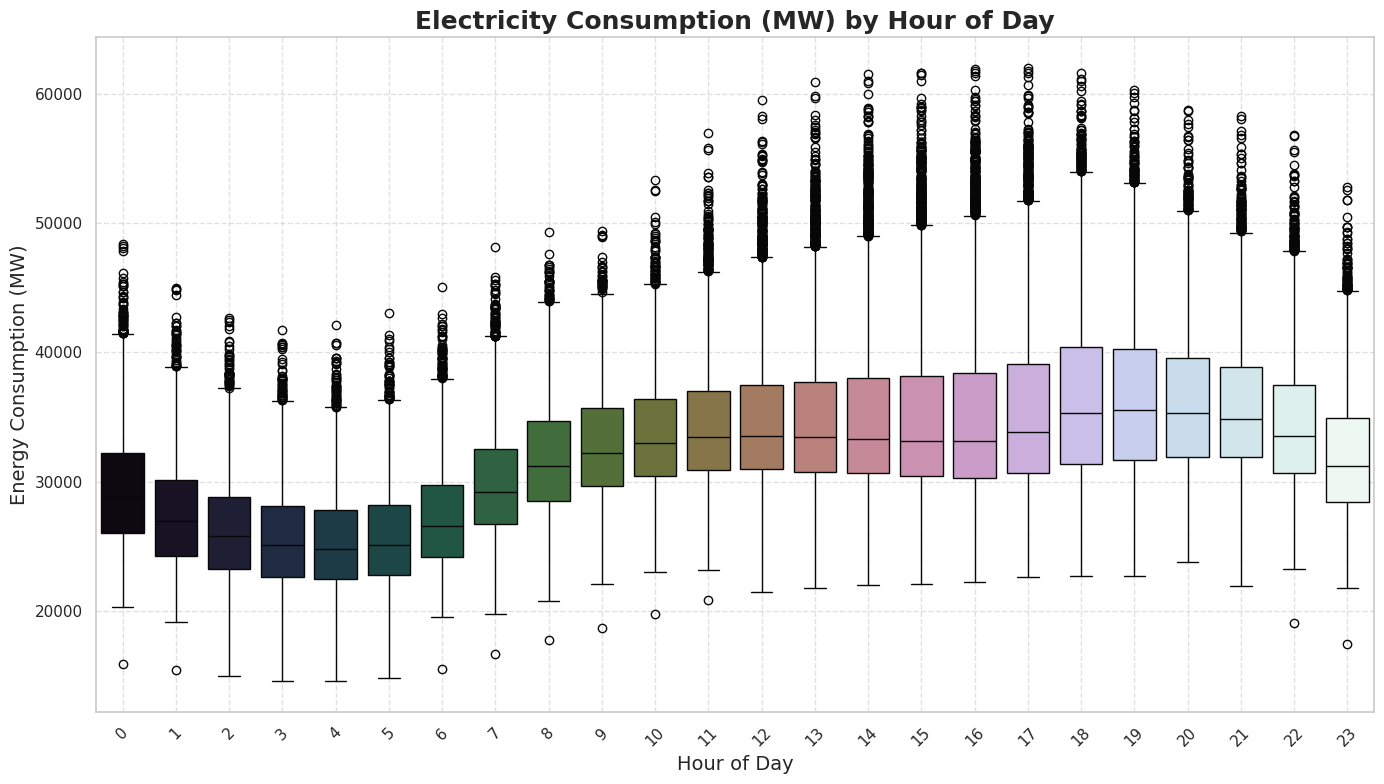

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set a modern, clean style
sns.set(style="whitegrid")

# Create a figure and axis
fig, ax = plt.subplots(figsize=(14, 8))

# Choose a vibrant color palette
palette = sns.color_palette("cubehelix", n_colors=24)  # for smooth transitions

# Create a boxplot with improved aesthetics
sns.boxplot(data=df, x='hour', y='PJME_MW', palette=palette, ax=ax)

# Improve axis labels and title
ax.set_title('Electricity Consumption (MW) by Hour of Day', fontsize=18, fontweight='bold')
ax.set_xlabel('Hour of Day', fontsize=14)
ax.set_ylabel('Energy Consumption (MW)', fontsize=14)

# Show grid
ax.grid(True, linestyle='--', alpha=0.6)

# Rotate x-axis labels if needed
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()
plt.show()


#**6.Create our Model**

In [ ]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'PJME_MW'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [ ]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:32605.13970	validation_1-rmse:31657.15729


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:47:34] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12584.35462	validation_1-rmse:11747.28803
[200]	validation_0-rmse:5837.33066	validation_1-rmse:5363.58554
[300]	validation_0-rmse:3923.28511	validation_1-rmse:4020.48045
[400]	validation_0-rmse:3447.54638	validation_1-rmse:3860.60088
[500]	validation_0-rmse:3288.19208	validation_1-rmse:3816.37862
[600]	validation_0-rmse:3206.55619	validation_1-rmse:3779.04119
[700]	validation_0-rmse:3153.61368	validation_1-rmse:3754.45684
[800]	validation_0-rmse:3114.34038	validation_1-rmse:3738.38209
[900]	validation_0-rmse:3084.39550	validation_1-rmse:3730.01893
[988]	validation_0-rmse:3060.25324	validation_1-rmse:3728.07396


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

#**7.Feature Importance**

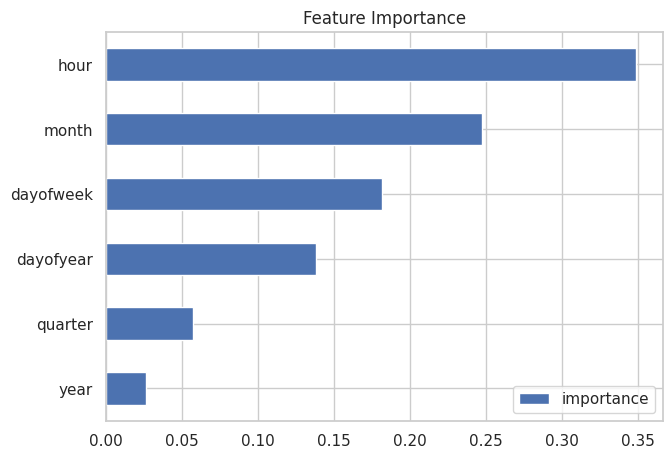

In [ ]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

#**8.Forecast on Test**

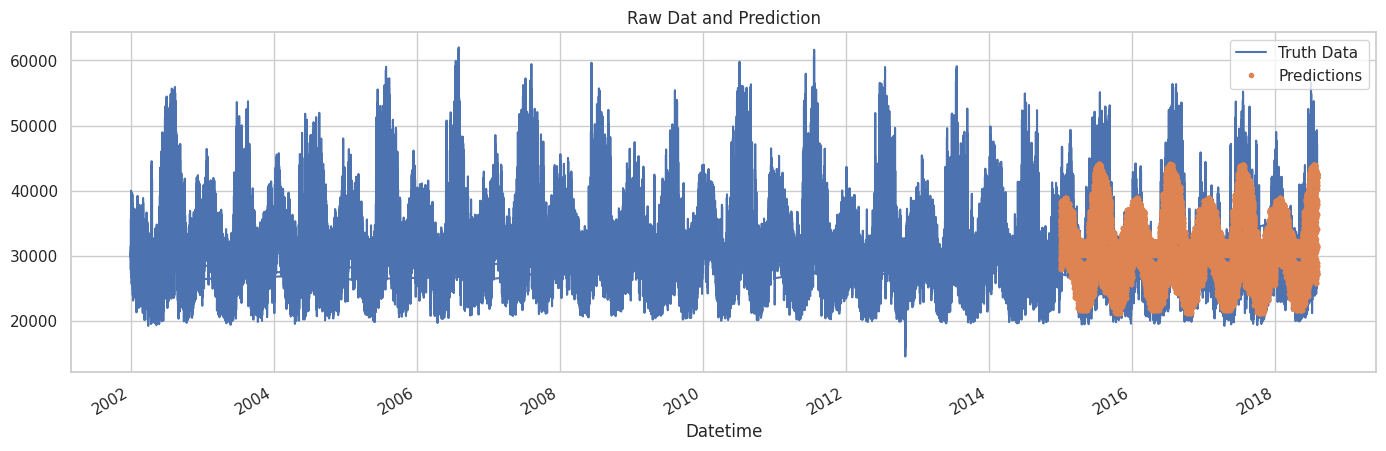

In [ ]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['PJME_MW']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

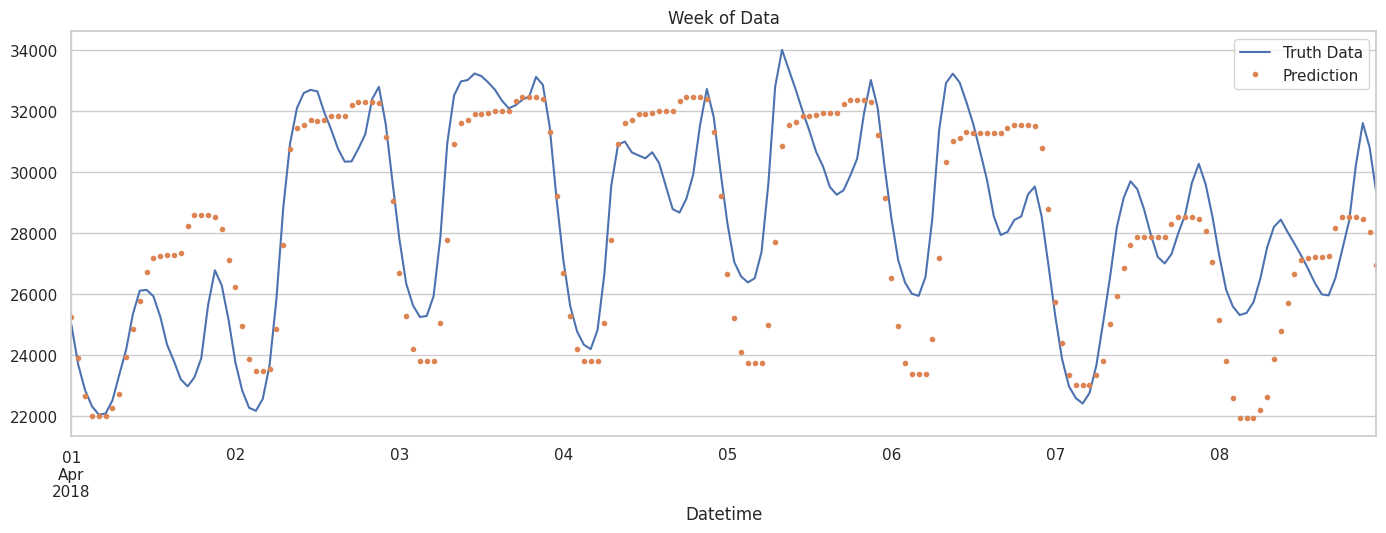

In [ ]:
# STEP 1: Add predictions to test
test['prediction'] = reg.predict(X_test)

# STEP 2: Create a clean DataFrame
test_plot = test[['PJME_MW', 'prediction']].copy()

# ✅ STEP 3: Sort the index!
test_plot = test_plot.sort_index()

# STEP 4: Slice the week
week_data = test_plot.loc['2018-04-01':'2018-04-08']

# STEP 5: Plot
ax = week_data['PJME_MW'].plot(figsize=(15, 5), title='Week of Data')
week_data['prediction'].plot(ax=ax, style='.')

plt.legend(['Truth Data', 'Prediction'])
plt.show()




#**9.Score (RMSE)**

In [ ]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 3726.80


#**10.Calculate Error-worst & best days**

In [ ]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

,error
date,
2016-08-13,12879.484619
2016-08-14,12772.887207
2015-02-20,11186.031494
2016-09-09,10966.513102
2016-09-10,10889.102214
2018-01-06,10642.975830
2016-08-12,10041.172689
2015-02-21,9988.168783
2015-02-16,9900.809326


In [ ]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=True).head(10)

,error
date,
2017-10-24,322.958008
2015-10-28,426.451335
2016-10-27,543.167155
2015-05-06,556.749674
2017-10-15,569.468262
2018-05-16,569.951009
2015-11-06,678.310140
2017-04-07,687.475911
2016-12-29,706.143392


#**11. Outlier Analysis and removal**

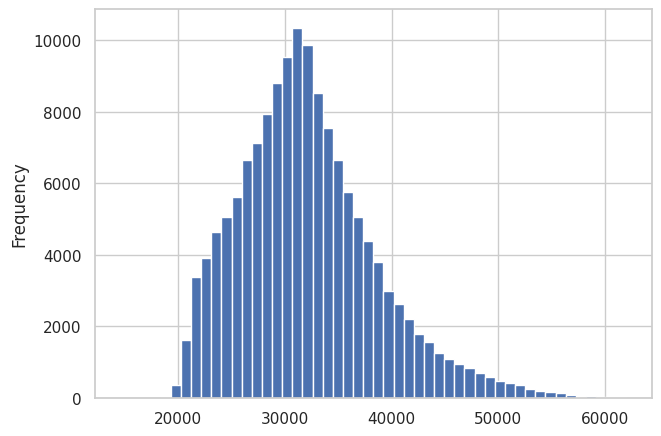

In [ ]:
df['PJME_MW'].dropna().plot(kind='hist', bins=50)  #Dropping Nans beforehand
plt.show()


**Show me a chart of only the electricity usage values that are unusually low — below 19,000 MW — and plot them as dots so I can easily see when those outliers happened**

<Axes: title={'center': 'Outliers'}, xlabel='Datetime'>

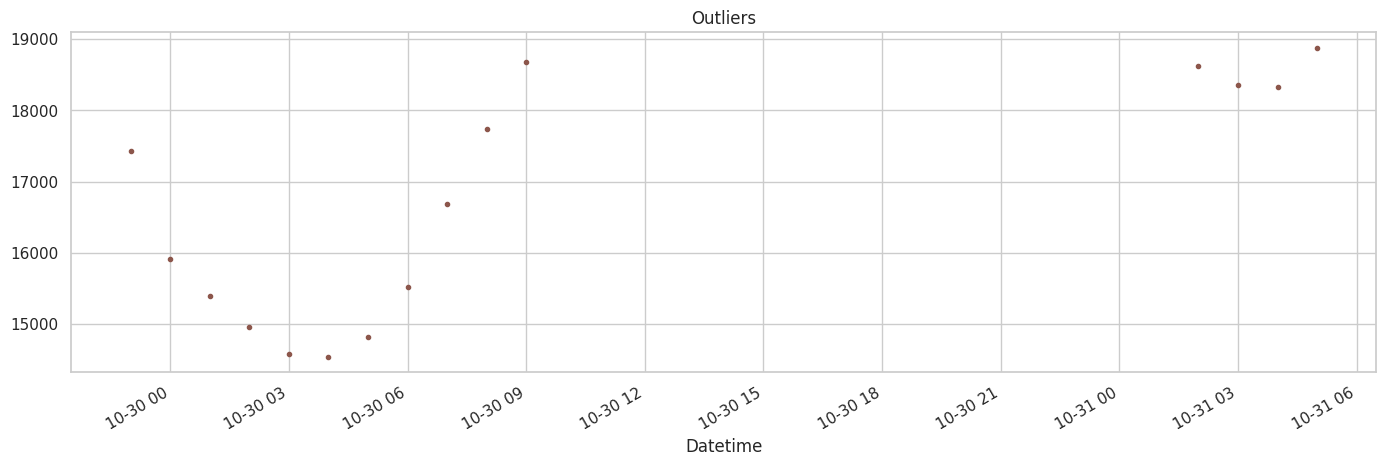

In [ ]:
df.query('PJME_MW < 19_000')['PJME_MW'] \
    .plot(style='.',
          figsize=(15, 5),
          color=color_pal[5],
          title='Outliers')

#**12.Reviewing: Train / Test Split**

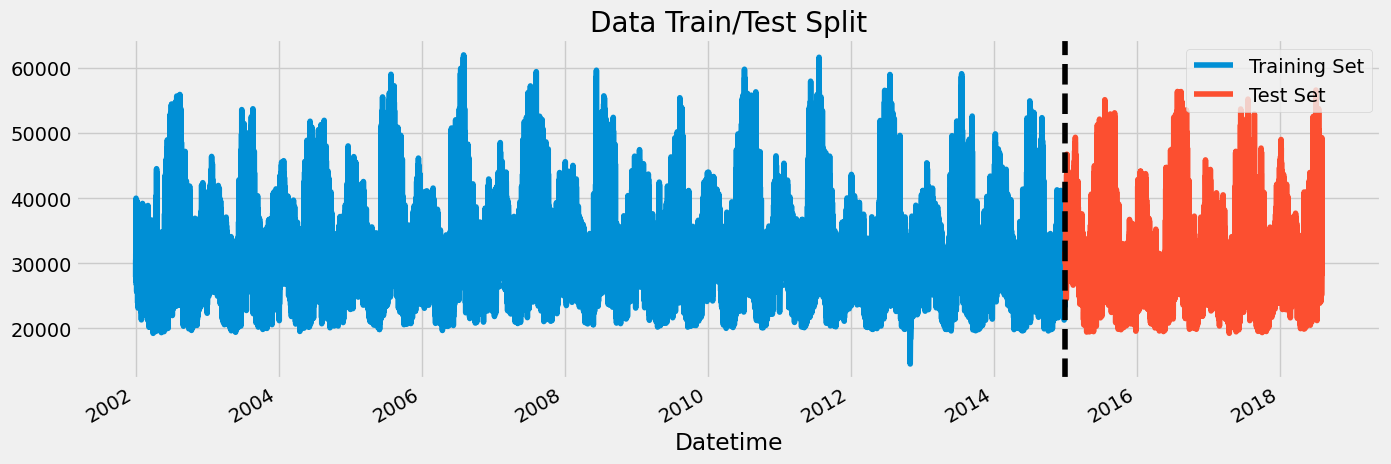

In [ ]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

#**13. Time Series Cross Validation**

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()

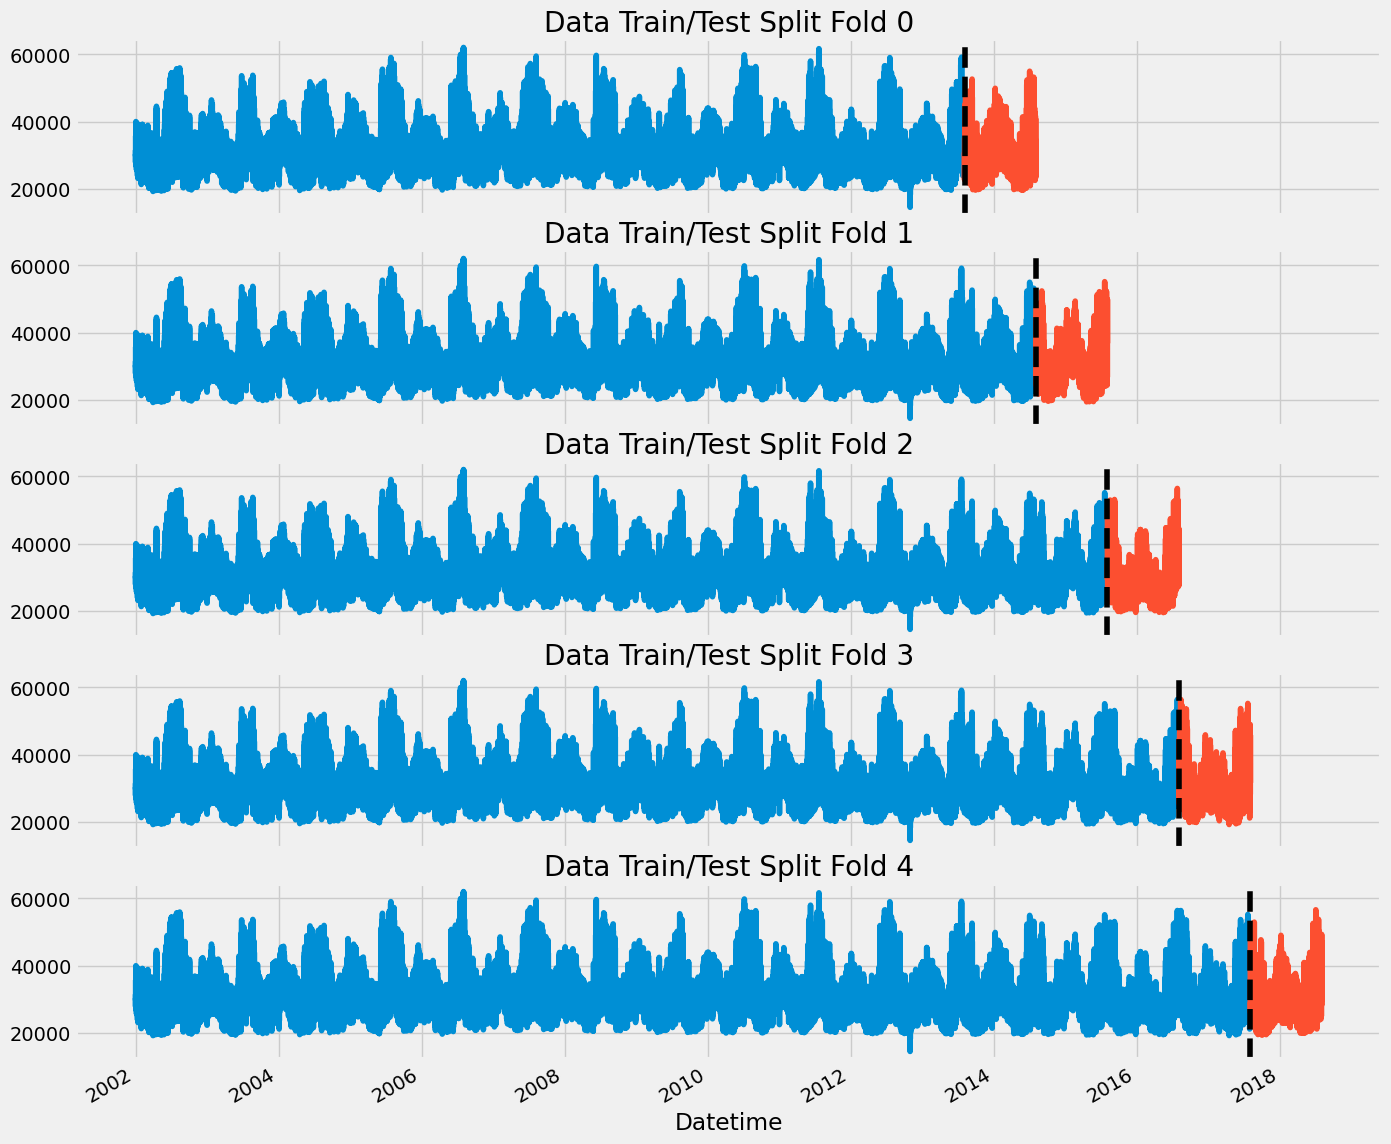

In [ ]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['PJME_MW'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['PJME_MW'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

#**14. Forecasting Horizon**

**The forecast horizon is the length of time into the future for which forecasts are to be prepared. These generally vary from short-term forecasting horizons (less than three months) to long-term horizons (more than two years).**

In [ ]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

#**15. Lag Features**

**What was the target (x) days in the past.**

In [ ]:
def add_lags(df):
    target_map = df['PJME_MW'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [ ]:
df = add_lags(df)

**16.Train Using Cross Validation**

In [ ]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3']
    TARGET = 'PJME_MW'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[0]	validation_0-rmse:32730.70639	validation_1-rmse:31956.68992


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:36:47] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12532.55336	validation_1-rmse:11909.41611
[200]	validation_0-rmse:5747.09818	validation_1-rmse:5364.37773
[300]	validation_0-rmse:3873.51430	validation_1-rmse:3899.82339
[400]	validation_0-rmse:3436.83821	validation_1-rmse:3761.31682
[472]	validation_0-rmse:3339.96200	validation_1-rmse:3766.70959
[0]	validation_0-rmse:32670.52224	validation_1-rmse:32138.89280


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:36:59] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12513.49682	validation_1-rmse:12224.28419
[200]	validation_0-rmse:5757.00363	validation_1-rmse:5660.61027
[300]	validation_0-rmse:3906.64261	validation_1-rmse:3931.54029
[400]	validation_0-rmse:3480.55395	validation_1-rmse:3594.18390
[500]	validation_0-rmse:3356.18631	validation_1-rmse:3521.16813
[600]	validation_0-rmse:3300.89593	validation_1-rmse:3485.23578
[700]	validation_0-rmse:3261.72962	validation_1-rmse:3464.90388
[800]	validation_0-rmse:3225.50605	validation_1-rmse:3438.64983
[900]	validation_0-rmse:3197.54901	validation_1-rmse:3430.10289
[999]	validation_0-rmse:3171.60041	validation_1-rmse:3423.30152
[0]	validation_0-rmse:32629.68486	validation_1-rmse:31073.29137


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:37:13] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12498.98688	validation_1-rmse:11138.63967
[200]	validation_0-rmse:5752.02891	validation_1-rmse:4816.91019
[300]	validation_0-rmse:3919.15626	validation_1-rmse:3552.07912
[400]	validation_0-rmse:3498.18633	validation_1-rmse:3492.18418
[0]	validation_0-rmse:32527.02577	validation_1-rmse:31475.38351


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:37:18] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12462.05865	validation_1-rmse:12020.44091
[200]	validation_0-rmse:5737.80165	validation_1-rmse:5797.76066
[300]	validation_0-rmse:3915.35694	validation_1-rmse:4384.39516
[400]	validation_0-rmse:3498.63311	validation_1-rmse:4169.62998
[500]	validation_0-rmse:3383.05051	validation_1-rmse:4111.26353
[550]	validation_0-rmse:3350.27015	validation_1-rmse:4112.59860
[0]	validation_0-rmse:32460.74594	validation_1-rmse:31463.90740


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:37:26] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12445.47503	validation_1-rmse:11959.11979
[200]	validation_0-rmse:5752.02184	validation_1-rmse:5613.55633
[300]	validation_0-rmse:3951.97347	validation_1-rmse:4156.62286
[400]	validation_0-rmse:3542.75274	validation_1-rmse:4008.30348
[437]	validation_0-rmse:3486.61061	validation_1-rmse:4006.62398


In [ ]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 3754.6872
Fold scores:[np.float64(3758.5256000579657), np.float64(3423.147857410298), np.float64(3476.121686141068), np.float64(4111.027693505075), np.float64(4004.6130268714915)]


#**16. Predicting the Future**

**Retraining on all data
To Predict the future we need an emtpy dataframe for future date ranges.
Run those dates through our feature creation code + lag creation**

In [ ]:
# Retrain on all data
df = create_features(df)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year',
            'lag1','lag2','lag3']
TARGET = 'PJME_MW'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',
                       n_estimators=500,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[0]	validation_0-rmse:32402.66145


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:54:54] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12426.65728
[200]	validation_0-rmse:5753.26464
[300]	validation_0-rmse:3973.71114
[400]	validation_0-rmse:3574.05442
[499]	validation_0-rmse:3459.67006


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

In [ ]:
df.index.max()

Timestamp('2018-08-03 00:00:00')

In [ ]:
# Create future dataframe
future = pd.date_range('2018-08-03','2019-08-01', freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [ ]:
future_w_features = df_and_future.query('isFuture').copy()

**Predict the future**

In [ ]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

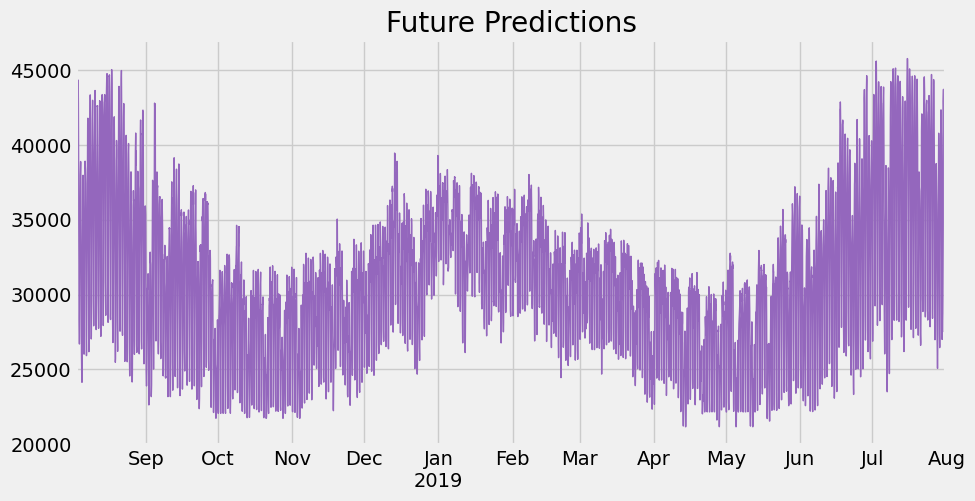

In [ ]:
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()

#**17.Saving Model For later**

In [ ]:
# Save model
reg.save_model('model.json')

In [ ]:
!ls -lh

total 564K
-rw-r--r-- 1 root root 559K Apr 20 05:50 model.json
drwxr-xr-x 1 root root 4.0K Apr 17 13:36 sample_data


<Axes: title={'center': 'Future Predictions'}>

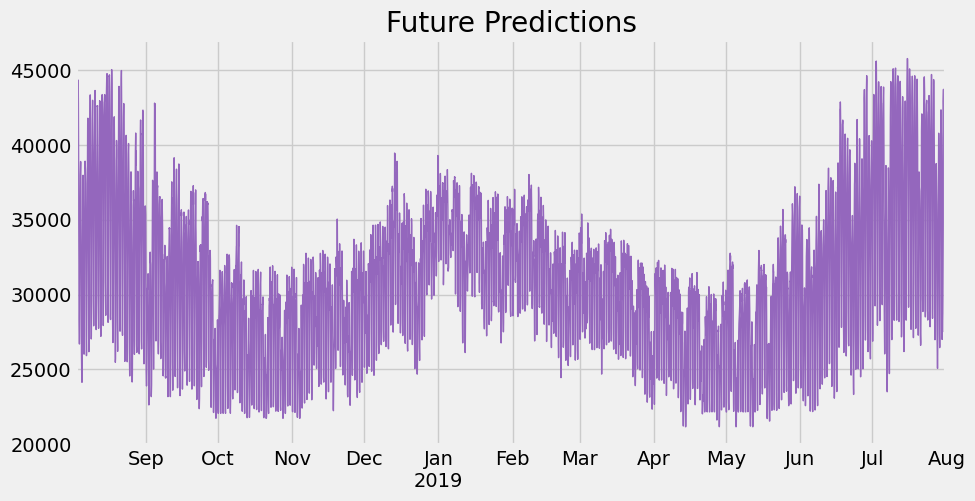

In [ ]:
reg_new = xgb.XGBRegressor()
reg_new.load_model('model.json')
future_w_features['pred'] = reg_new.predict(future_w_features[FEATURES])
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1, lw=1,
                               title='Future Predictions')